After nominal pass:
- Determine optimal #HCP from nominal associations
- Visualize gene expression regressed by covariates, check batch effect
- Maybe: Relative log-expression RLE plots

After permutation pass:
- check beta approximated permutation pval
- QTL TSS distance density plot
- Compare eGene across ancestries, upsetR
- Venn graph for fetal vs PEC, GTEx


In [1]:
library(ggplot2)
library(data.table)

### 1: Optimal number of HCP

#### Mixed ancestry

In [14]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_nominal_", i, 
                                           "hcp/significant_feature_count.txt"))[,1]
}

In [15]:
df

HCP,Count
<dbl>,<int>
10,19840
20,21373
30,21884
40,22374
50,22607
60,22807
70,22854
80,22895
90,23030


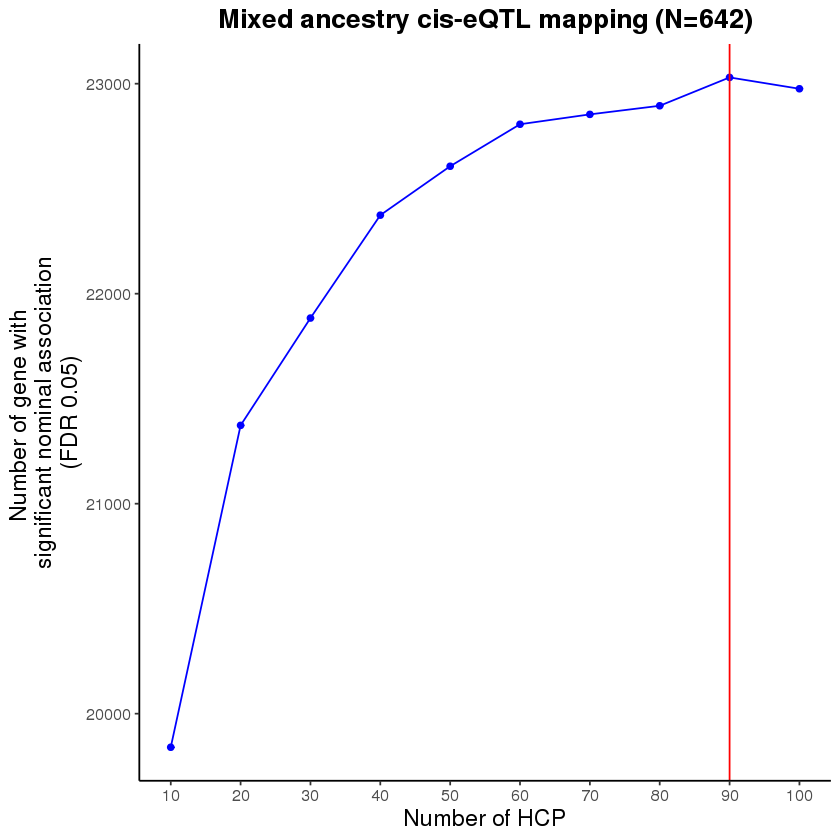

In [16]:
p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 90, color = "red") +
    labs(title = "Mixed ancestry cis-eQTL mapping (N=642)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p1

In [17]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/mixed_nominal.png", p1, width = 6, height = 6)

#### EUR

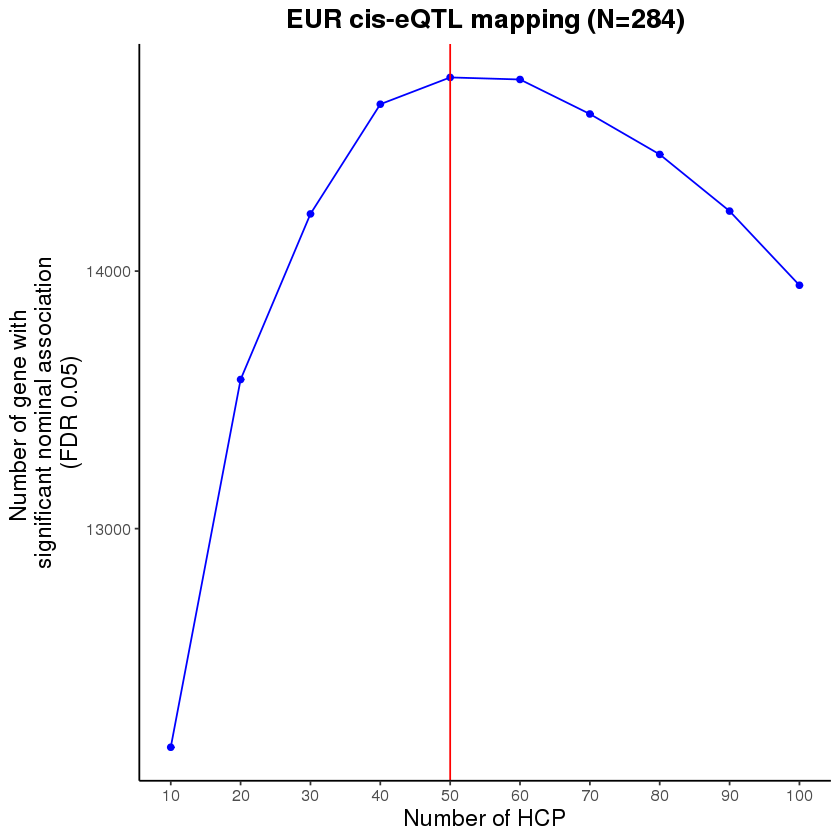

In [18]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("~/project-gandalm/isoform_twas/eqtl_new/results/eur_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p3 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 50, color = "red") +
    labs(title = "EUR cis-eQTL mapping (N=284)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3

In [19]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/eur_nominal.png", p3, width = 6, height = 6)

#### AMR

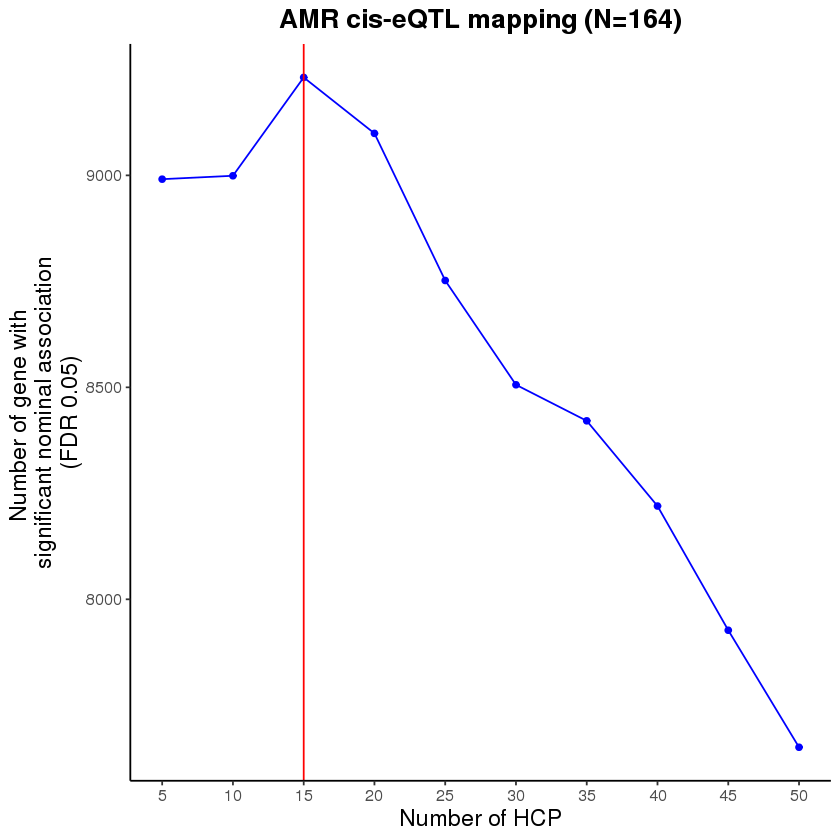

In [20]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("~/project-gandalm/isoform_twas/eqtl_new/results/amr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p4 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 15, color = "red") +
    labs(title = "AMR cis-eQTL mapping (N=164)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p4

In [21]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/amr_nominal.png", p4, width = 6, height = 6)

#### AFR

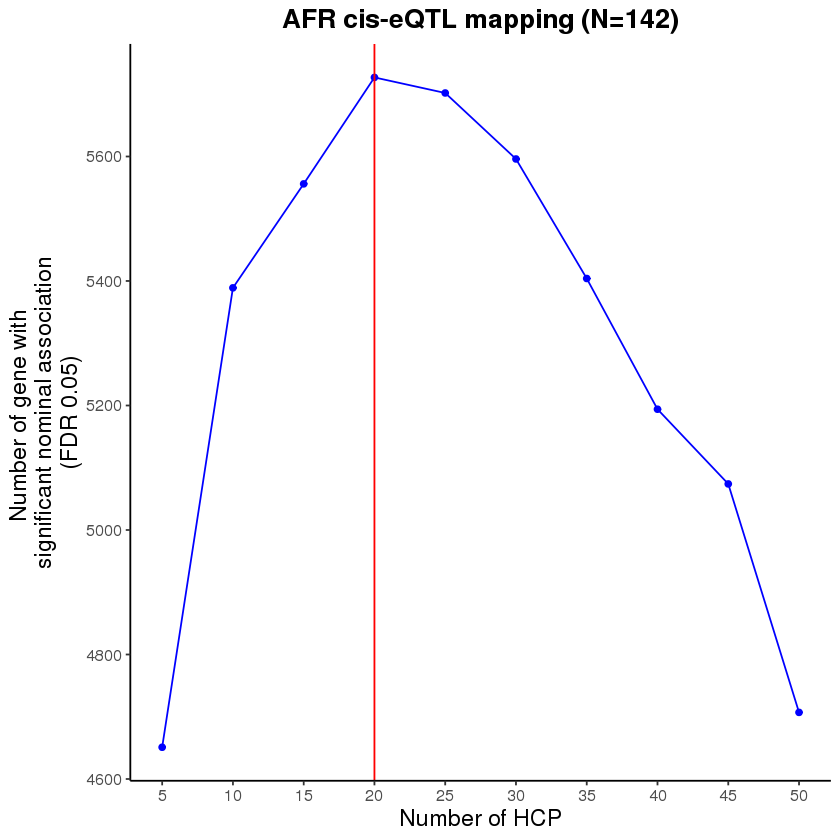

In [25]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("~/project-gandalm/isoform_twas/eqtl_new/results/afr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p5 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 20, color = "red") +
    labs(title = "AFR cis-eQTL mapping (N=142)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p5

In [26]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/afr_nominal.png", p5, width = 6, height = 6)

### 2: Gene expression regression, check batch effects

#### Mixed ancestry

In [31]:
datExpr <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [32]:
datExpr_noCombat <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.noComBat.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [33]:
cov <- read.table("~/project-gandalm/isoform_twas/eqtl_new/data/90hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

In [34]:
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

In [35]:
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [36]:
walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

In [37]:
# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

In [38]:
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

In [39]:
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

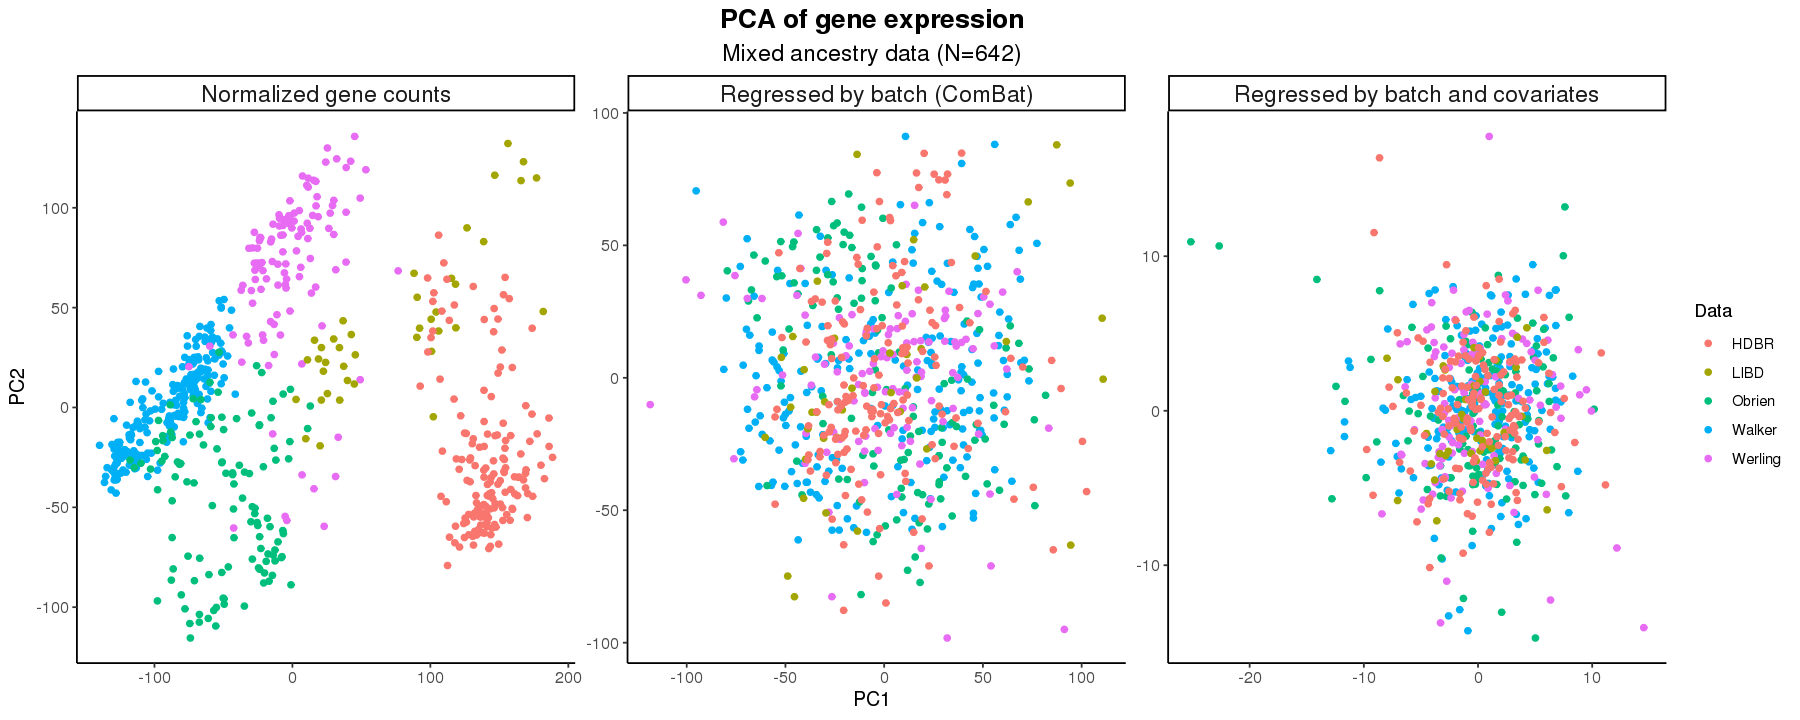

In [40]:
options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p2 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "Mixed ancestry data (N=642)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p2

In [41]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/mixed_regress.png", p2, width = 15, height = 6)

#### EUR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.tsv", :
“Detected 284 column names but the data has 285 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.noComBat.tsv", :
“Detected 284 column names but the data has 285 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


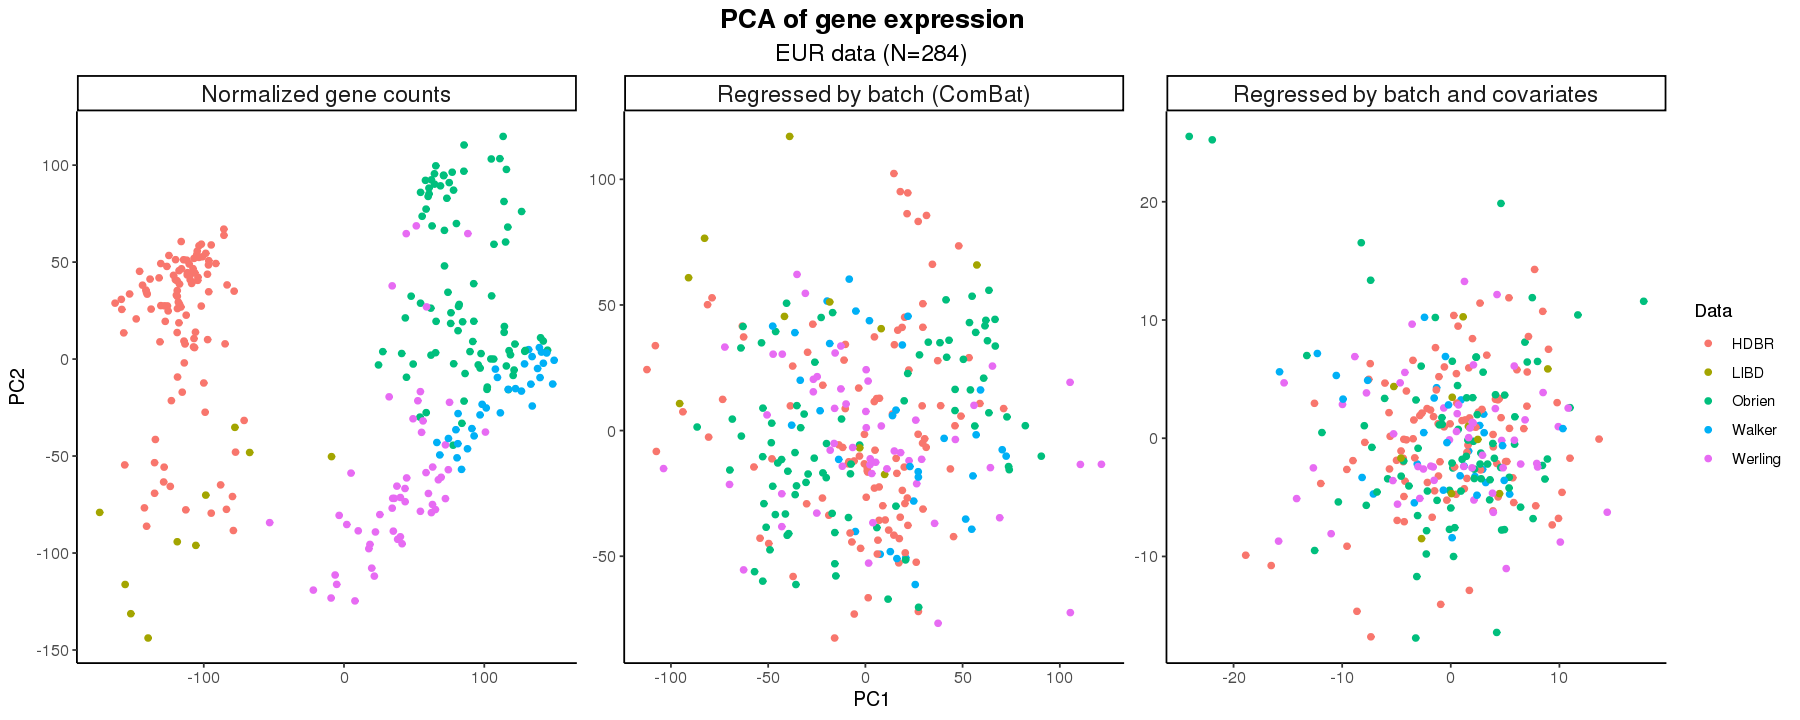

In [28]:
datExpr <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("~/project-gandalm/isoform_twas/eqtl_new/data/eur/50HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p6 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "EUR data (N=284)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p6

In [42]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/eur_regress.png", p6, width = 15, height = 6)

#### AMR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.noComBat.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


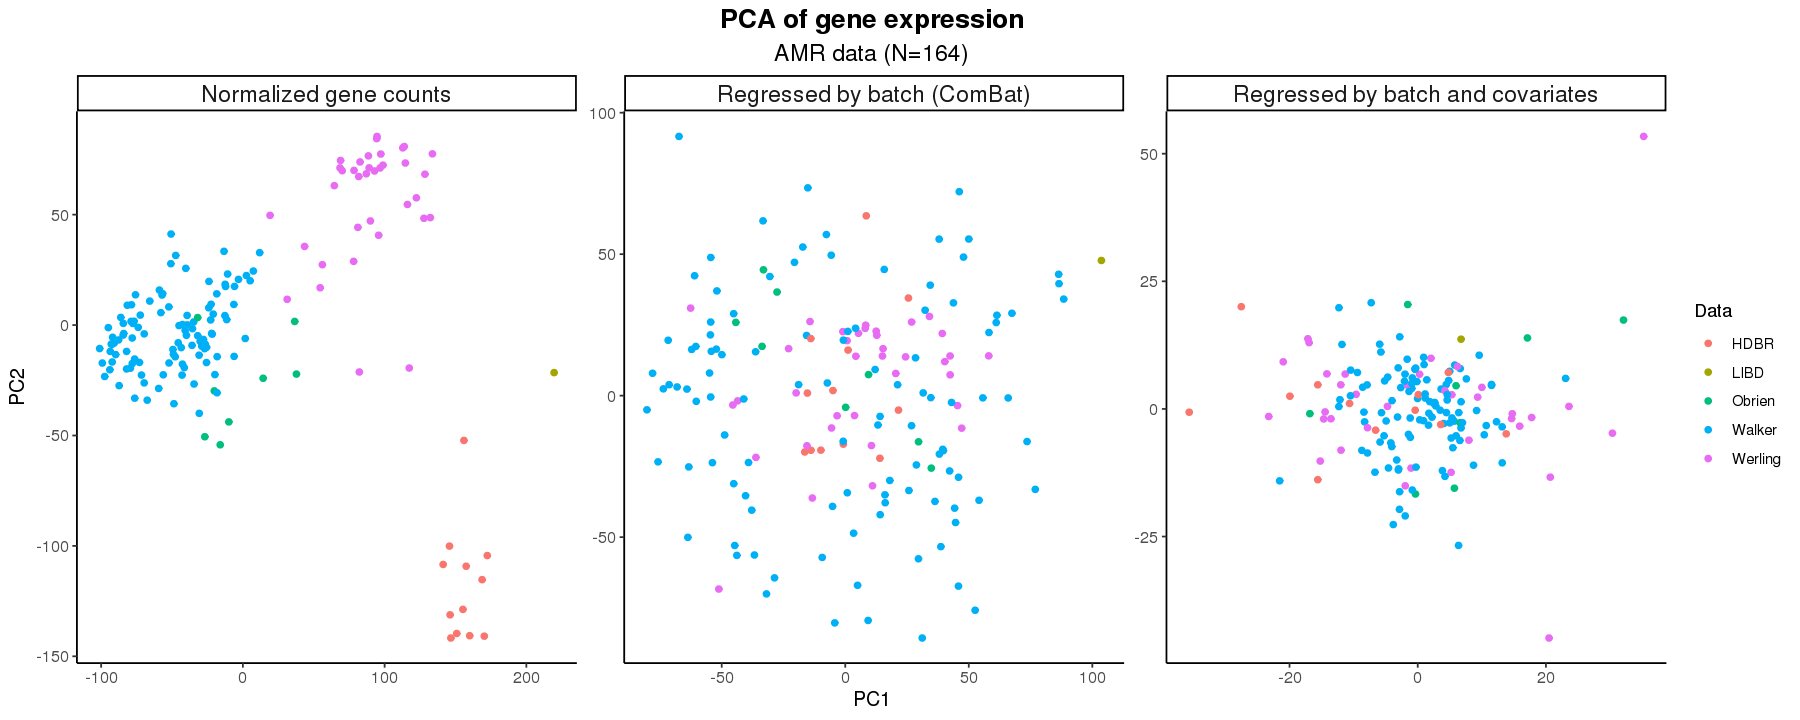

In [43]:
datExpr <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("~/project-gandalm/isoform_twas/eqtl_new/data/amr/15HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p7 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "AMR data (N=164)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p7

ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/amr_regress.png", p7, width = 15, height = 6)

#### AFR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.tsv", :
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.noComBat.tsv", :
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


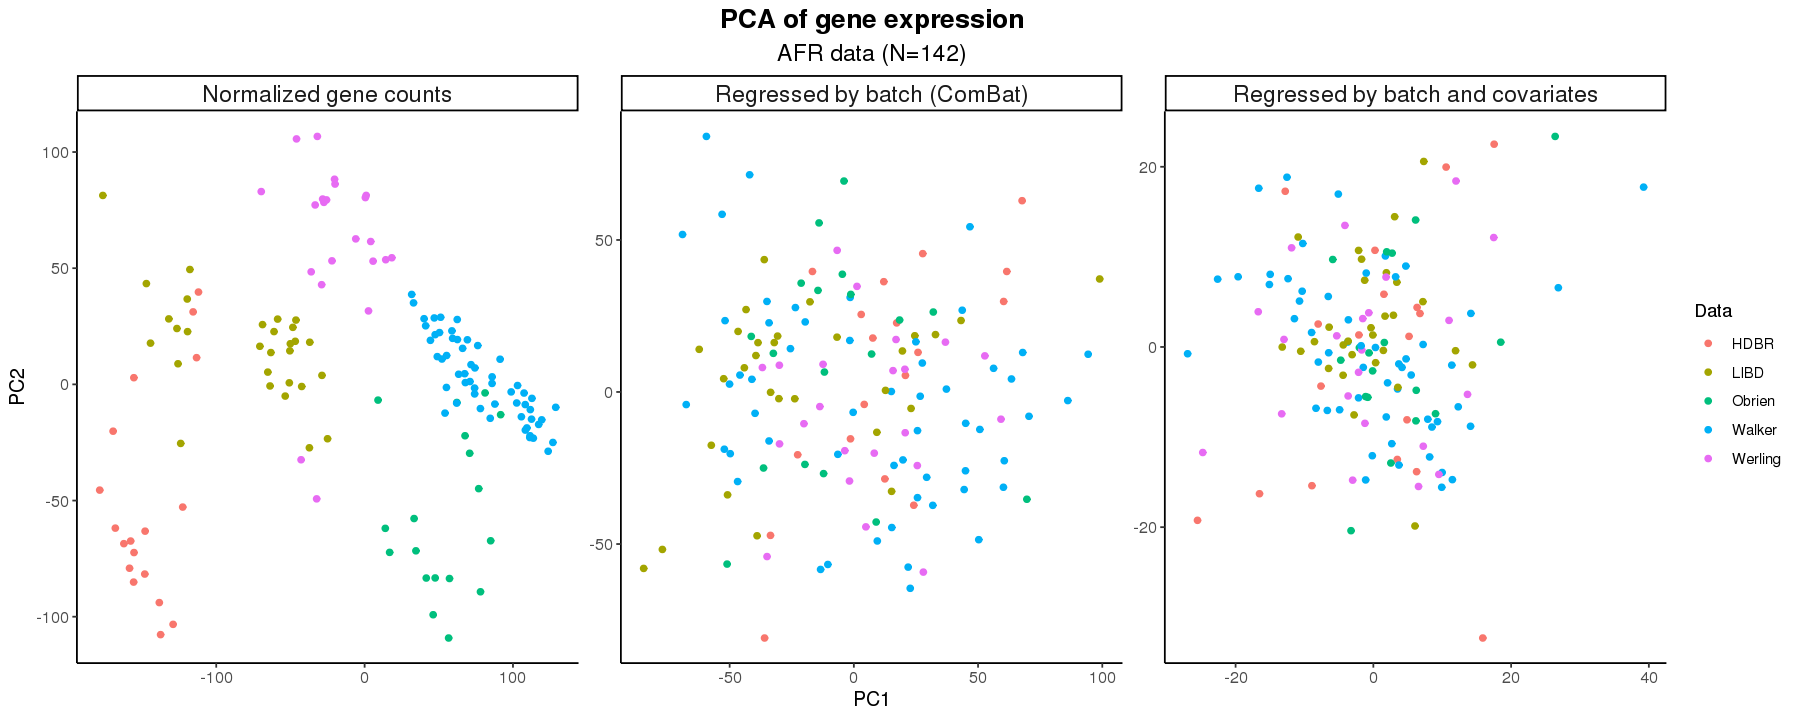

In [44]:
datExpr <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("~/project-gandalm/isoform_twas/eqtl_new/data/afr/20HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p8 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "AFR data (N=142)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p8

ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/afr_regress.png", p8, width = 15, height = 6)

### 3: Check beta-approximated permutation pval

In [5]:
mixed <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/all.chunks.txt.gz", data.table=F)
colnames(mixed) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")

Warning message:
“Removed 416 rows containing missing values (geom_point).”


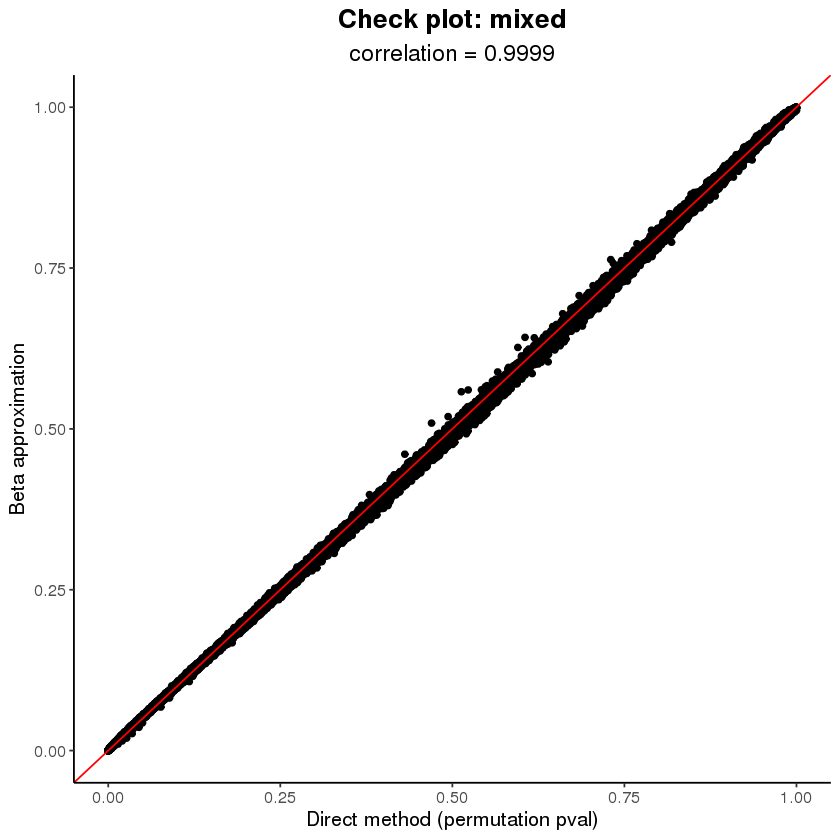

In [11]:
p <- ggplot(mixed, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: mixed",
         subtitle = "correlation = 0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [17]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/mixed_check.png", p, width = 6, height = 6)

Warning message:
“Removed 416 rows containing missing values (geom_point).”


Warning message:
“Removed 416 rows containing missing values (geom_point).”
Warning message:
“Removed 416 rows containing missing values (geom_point).”


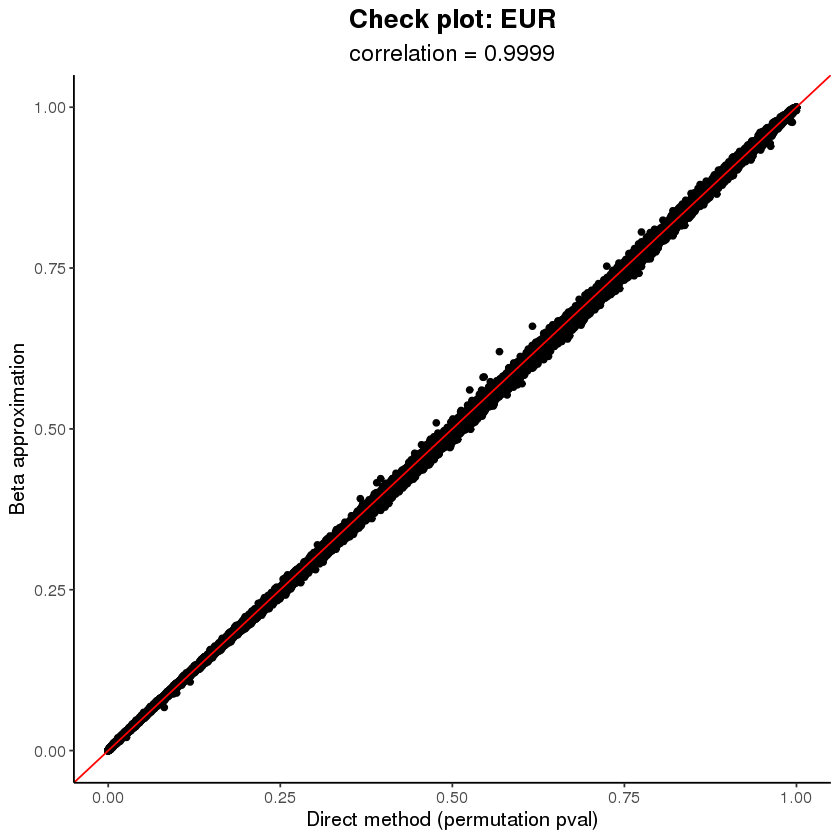

In [18]:
eur <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/eur_perm_50HCP/all.chunks.txt.gz", data.table=F)
colnames(eur) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
p1 <- ggplot(eur, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: EUR",
         subtitle = "correlation = 0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p1
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/eur_check.png", p1, width = 6, height = 6)

Warning message:
“Removed 416 rows containing missing values (geom_point).”
Warning message:
“Removed 416 rows containing missing values (geom_point).”


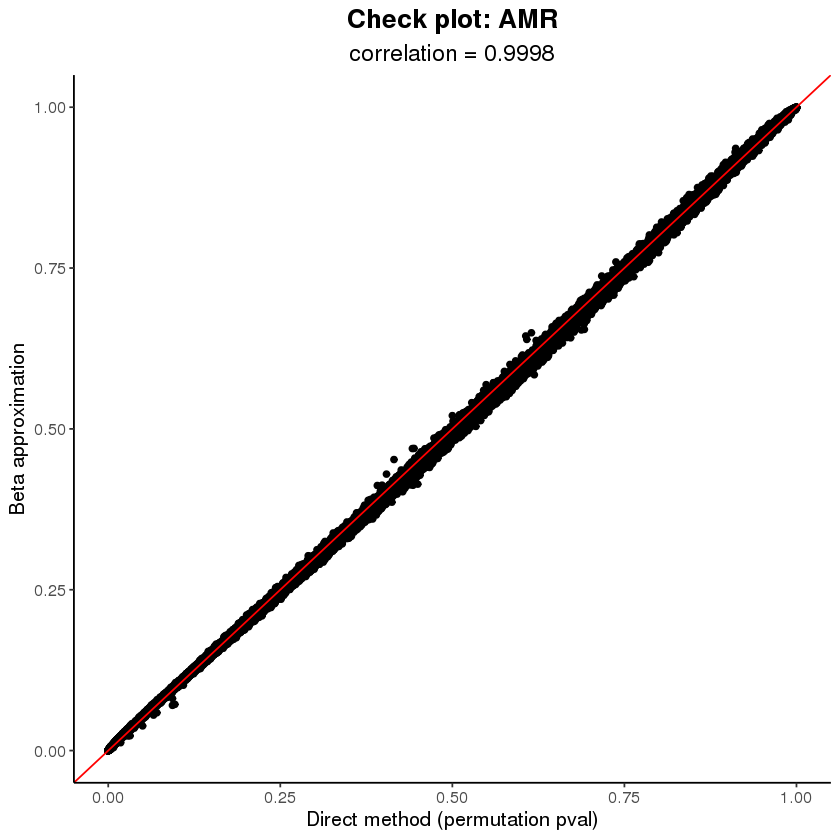

In [20]:
amr <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/amr_perm_15HCP/all.chunks.txt.gz", data.table=F)
colnames(amr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
p2 <- ggplot(amr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AMR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p2
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/amr_check.png", p2, width = 6, height = 6)

Warning message:
“Removed 416 rows containing missing values (geom_point).”
Warning message:
“Removed 416 rows containing missing values (geom_point).”


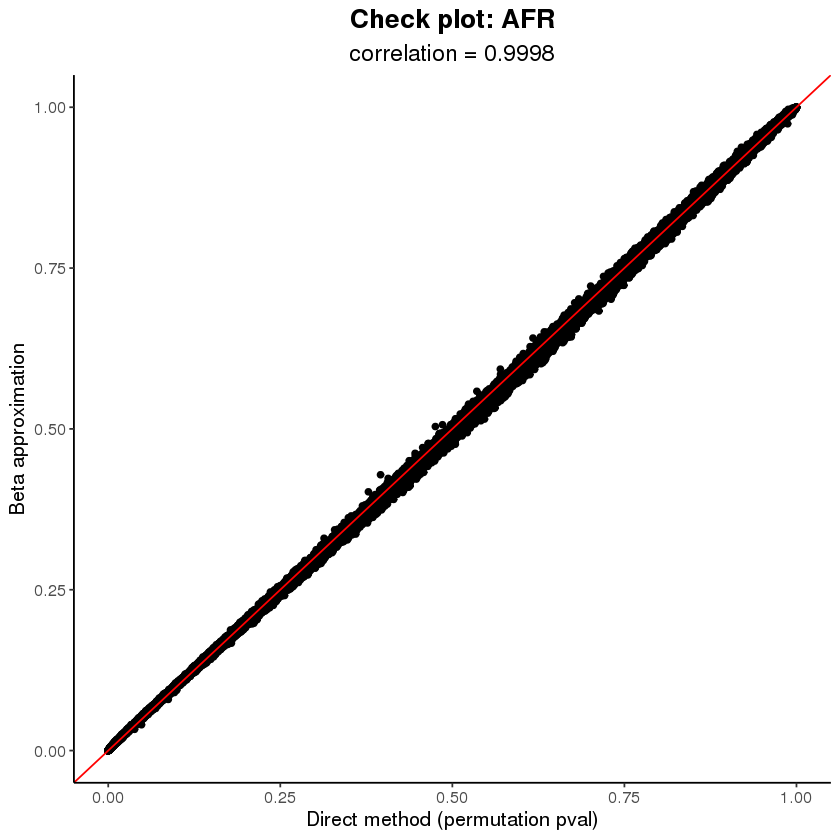

In [21]:
afr <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/afr_perm_20HCP/all.chunks.txt.gz", data.table=F)
colnames(afr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
p3 <- ggplot(afr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AFR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/afr_check.png", p3, width = 6, height = 6)

### 4: dTSS of top eQTL

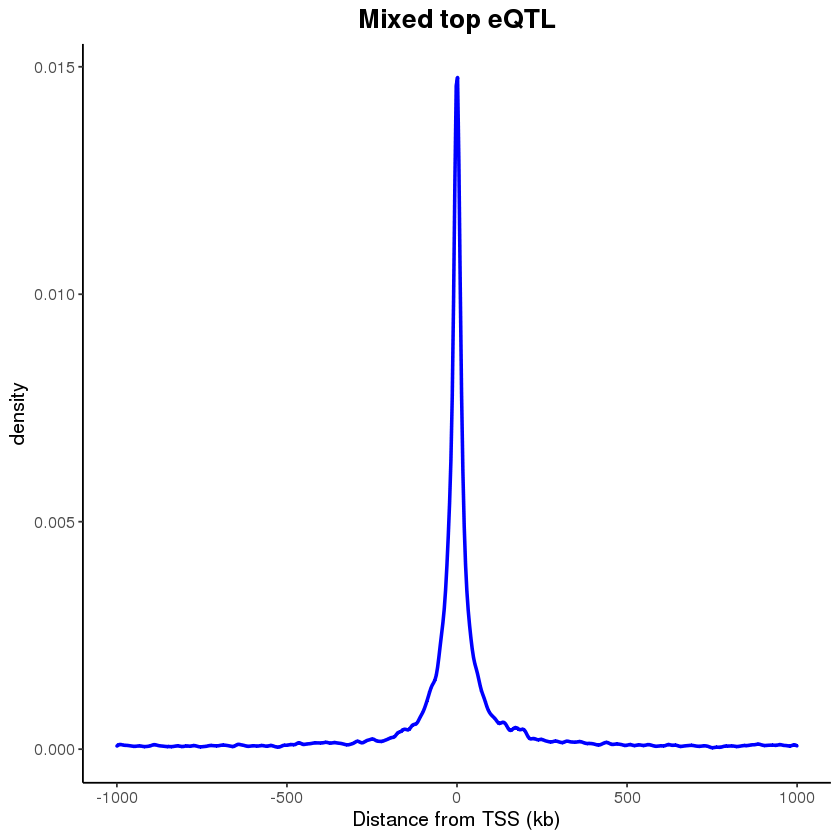

In [34]:
mixed_sig <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/sig_pheno.txt", header = T, stringsAsFactors = F)
mixed_sig$dist_kb <- mixed_sig$dist/1000
p <- ggplot(mixed_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "Mixed top eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [36]:
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/mixed_dist.png", p, height = 6, width = 6)

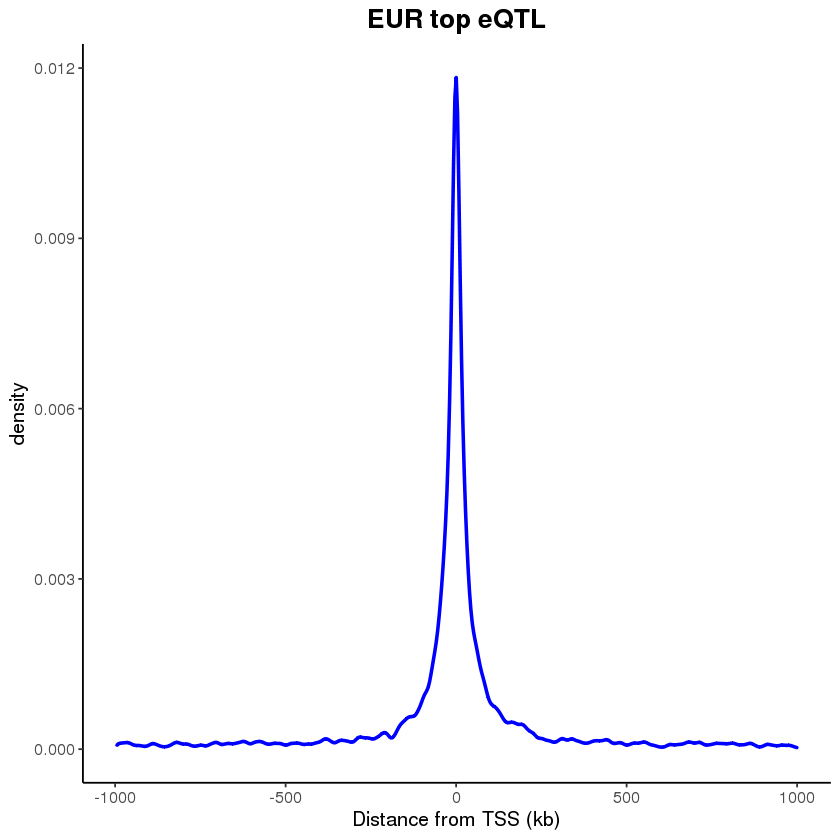

In [37]:
eur_sig <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/eur_perm_50HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
eur_sig$dist_kb <- eur_sig$dist/1000
p1 <- ggplot(eur_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "EUR top eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p1
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/eur_dist.png", p1, height = 6, width = 6)

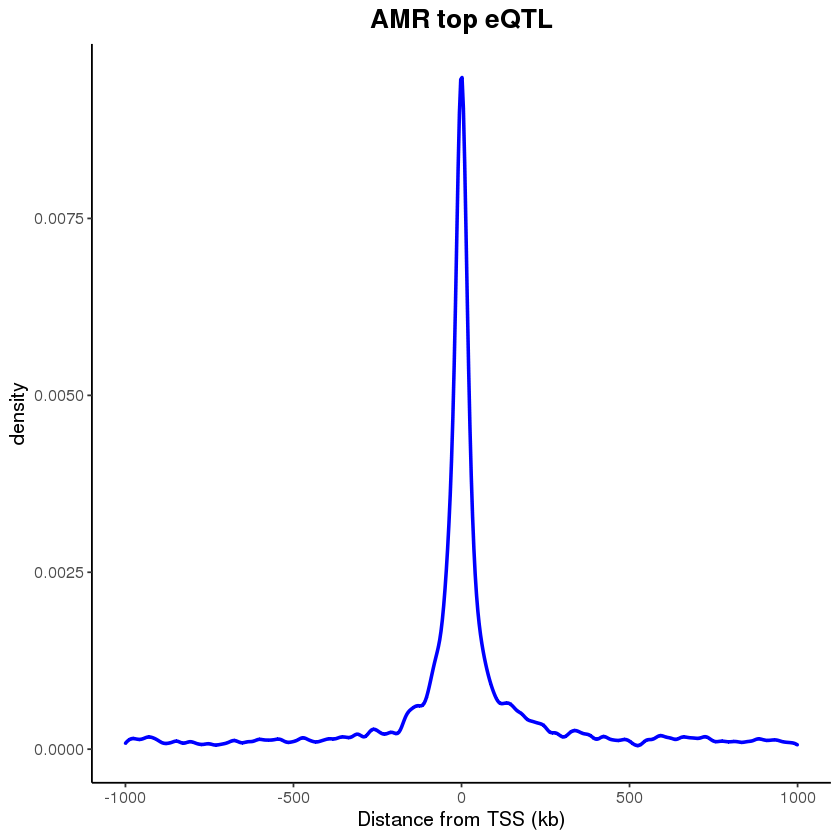

In [38]:
amr_sig <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/amr_perm_15HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
amr_sig$dist_kb <- amr_sig$dist/1000
p2 <- ggplot(amr_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "AMR top eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p2
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/amr_dist.png", p2, height = 6, width = 6)

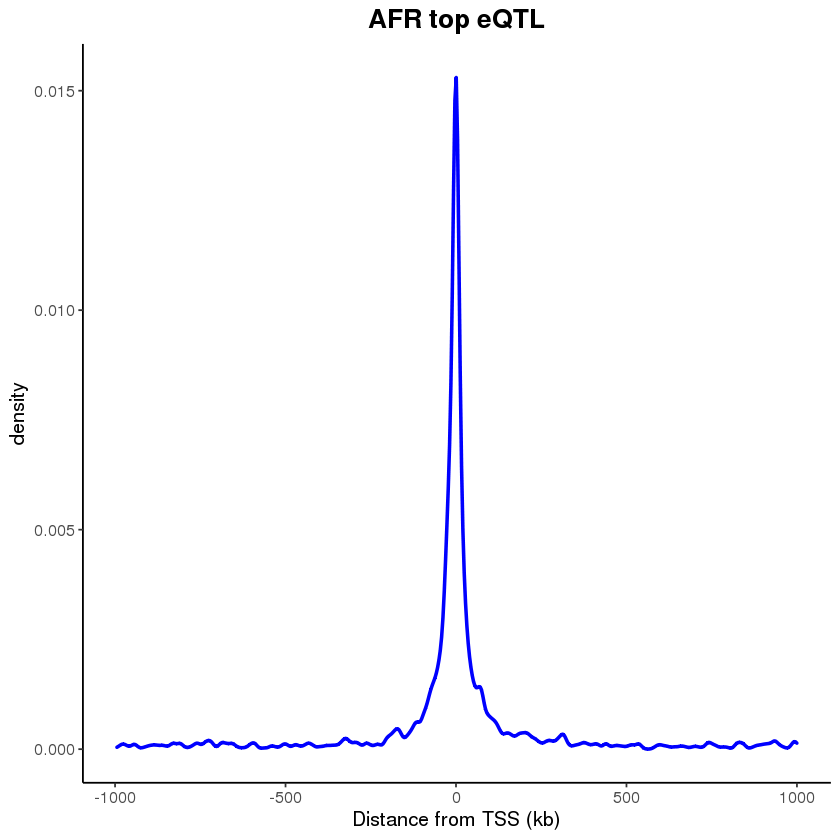

In [39]:
afr_sig <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/afr_perm_20HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
afr_sig$dist_kb <- afr_sig$dist/1000
p3 <- ggplot(afr_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "AFR top eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/eqtl_new/figures/afr_dist.png", p3, height = 6, width = 6)

### 5: Ancestry eGene UpsetR

In [40]:
mixed_gene <- unique(mixed_sig$pid)
eur_gene <- unique(eur_sig$pid)
amr_gene <- unique(amr_sig$pid)
afr_gene <- unique(afr_sig$pid)

In [41]:
genes <- list(Mixed = mixed_gene,
            EUR = eur_gene,
            AMR = amr_gene,
            AFR = afr_gene)

In [31]:
library(UpSetR)

In [42]:
pdf(file="~/project-gandalm/isoform_twas/eqtl_new/figures/upsetr_egene.pdf", onefile=F)
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of eGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Mixed"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Mixed"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1))
dev.off()

png 
  2

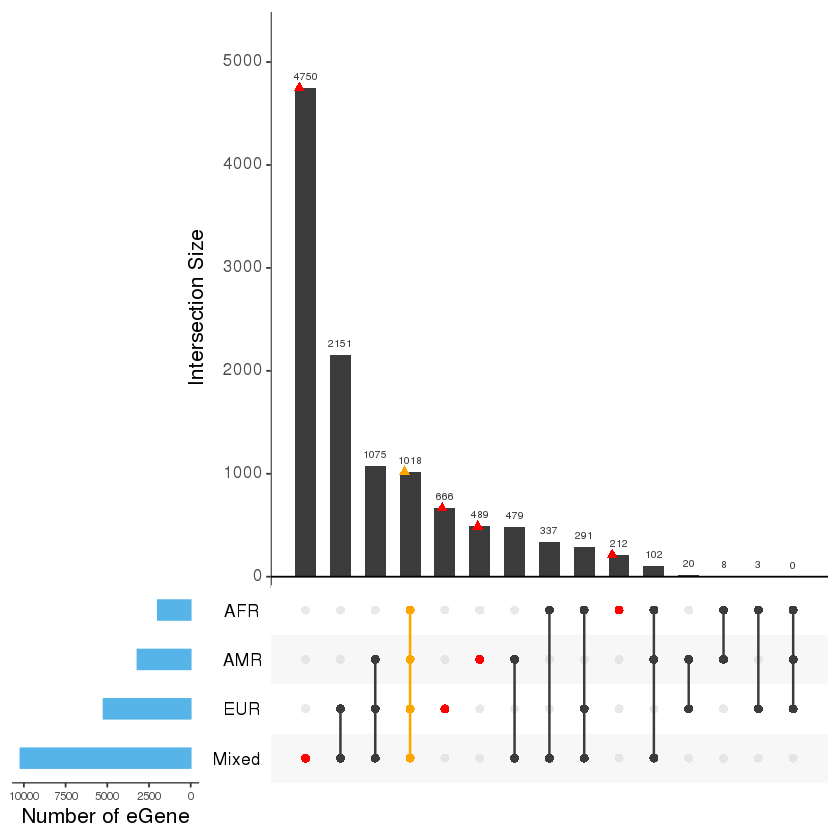

In [43]:
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of eGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Mixed"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Mixed"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1))

### 6: eGene venn PsychENCODE, GTEx cortex